In [1]:
from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import lightgbm

import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import shap

In [2]:
def query_status(eq_id):
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'TFM4CEBERUS',
                password = 'TFM4CEBERUS',
                hostname = 'ome-db.bth.infineon.com',
                port = '1538',
                database = 'ome'
                )
            )
    except Exception as e:
        print(str(e))

    query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
            from (SELECT
              eq.eq_id, eq.name, eq.eq_type_ident
            , data.timestamp_start,data.timestamp_end
            , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
            , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
            , level5s.state_name
            , level5.state_name Level5_Name, level5.state_sign Level5
            , level4.state_name Level4_Name, level4.state_sign Level4
            , level3.state_name Level3_Name, level3.state_sign Level3
            ,mh.device
            ,mh.package,
            mh.lotid as lot,
            mh.product,
            mh.operation

            FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
            , OMEADMIN.EQUIPMENT_INSTANCES eq
            , V_EQ_STATES level5s
            , OMEADMIN.DEF_STANDARD_STATEMODEL level5
            , OMEADMIN.DEF_STANDARD_STATEMODEL level4
            , OMEADMIN.DEF_STANDARD_STATEMODEL level3
            , OMEDATA.METAKEY_HISTORY mh

            WHERE data.eq_ident  = eq.eq_ident
            AND  data.eq_status = level5s.state_ident(+)
            AND level5.state_ident = data.tr25_5_status
            AND level4.state_ident = data.tr25_4_status
            AND level3.state_ident = data.tr25_3_status
            AND  data.metakey_ident =mh.ident(+)
            and data.timestamp_start > sysdate - 1050)
            where eq_id = '{eq_id}'
            and TIMESTAMP_START <= to_date('30/9/2021', 'dd/mm/yyyy')
            ORDER BY TIMESTAMP_START"""

    status = pd.read_sql(query, engine)
    status.columns = map(lambda x: str(x).upper(), status.columns) 

    return status

In [3]:
wba127_alarm = pd.read_excel("../Data/WBA127_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba127_status = query_status('WBA127')
# do not have to clean status data since the only information we need is that major down time

# 1. First do some EDA on the alarm data to find out suitable data to be used

In [4]:
# find out which shift did the alarm happen

query_filter = (wba127_alarm['DT_SET'].dt.hour<7)|(wba127_alarm['DT_SET'].dt.hour>=19)
wba127_alarm['SHIFT'] = np.where((query_filter), 'NIGHT', 'MORNING')
wba127_alarm['HOUR'] = wba127_alarm['DT_SET'].dt.hour

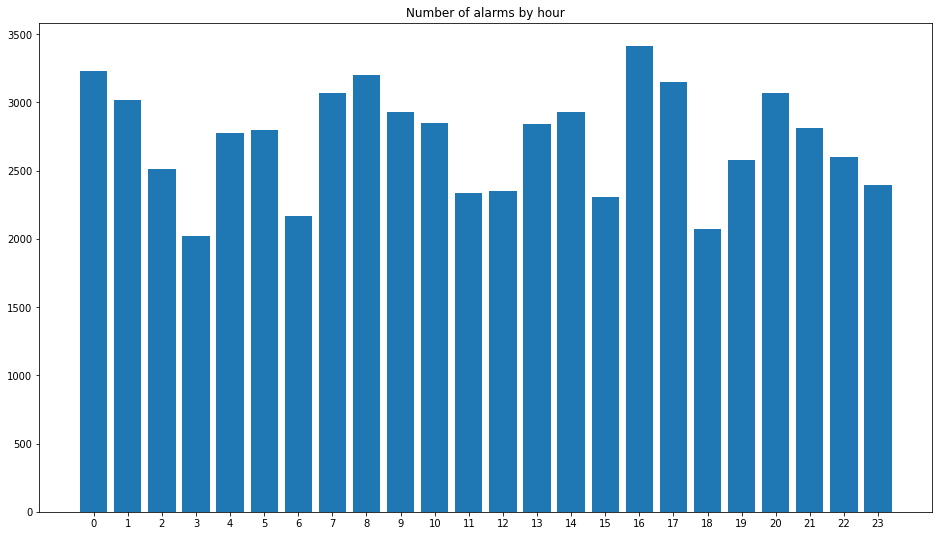

In [5]:
# does not observe any pattern

group = wba127_alarm.groupby(['HOUR']).agg({'Alarm ID':'count'}).reset_index()

plt.figure(figsize=(16,9))
plt.bar(group['HOUR'], group['Alarm ID'])
plt.xticks(group['HOUR'])
plt.title('Number of alarms by hour')
plt.show()

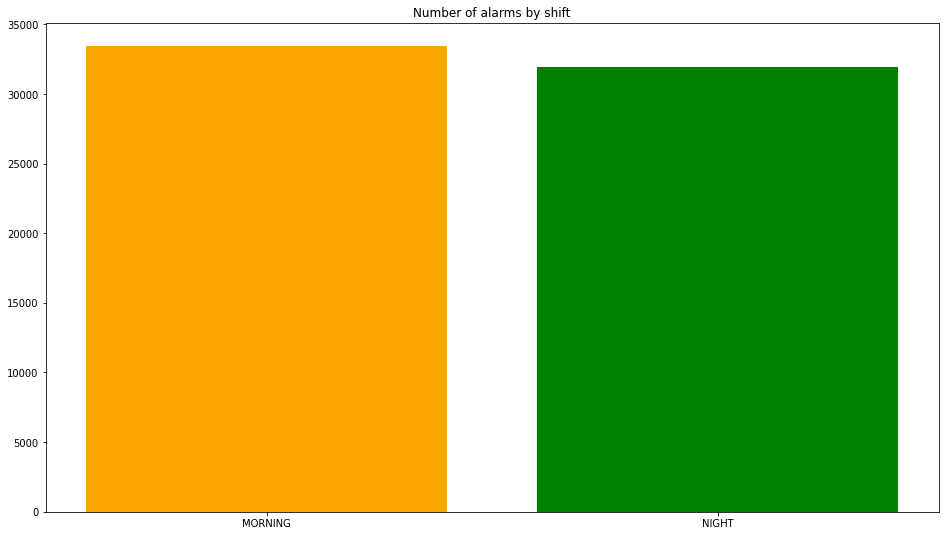

In [6]:
# even distribution across shift as well

shift = wba127_alarm.groupby(['SHIFT']).agg({'Alarm ID':'count'}).reset_index()

plt.figure(figsize=(16,9))
plt.bar(shift['SHIFT'], shift['Alarm ID'], color=['orange', 'green'])
plt.xticks(shift['SHIFT'])
plt.title('Number of alarms by shift')
plt.show()

In [7]:
store -r wba127_clean_status

In [8]:
# compute whether or not would there be a major down in the next 24 hours for each alarm event

threshold = 3600
hour = 24

MAJOR_DOWN = []
for idx, row in wba127_alarm.iterrows():
    start = row['DT_SET']
    end = start+timedelta(hours=hour)
    frame = wba127_clean_status[(wba127_clean_status['TIMESTAMP_START']>=start) & \
                                 (wba127_clean_status['TIMESTAMP_START']<=end)]
    UD = frame.loc[frame['LEVEL3']=='UDT']

    if len(UD) == 0: #no record within this 6 hours:
        MAJOR_DOWN.append(0)
    else:
        time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
        if any(time_diff>=threshold): #threshold = 3600s
            MAJOR_DOWN.append(1)
        else:
            MAJOR_DOWN.append(0)

wba127_alarm['24 HOUR DOWN'] = MAJOR_DOWN

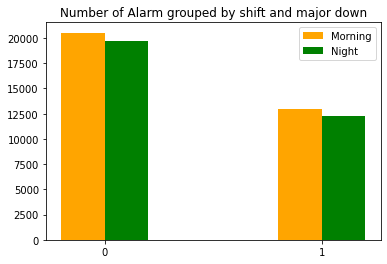

In [9]:
# no relationship between morning/night shift and the occurence of major down

down = wba127_alarm.groupby(['24 HOUR DOWN', 'SHIFT']).agg({'Alarm ID':'count'}).reset_index()
morning_shift = down.loc[down['SHIFT']=='MORNING']['Alarm ID']
night_shift = down.loc[down['SHIFT']=='NIGHT']['Alarm ID']

width = 0.2
ind = np.arange(2)

plt.bar(ind-width/2, morning_shift, width=width, color='orange', label='Morning')
plt.bar(ind+width/2, night_shift, width=width, color='green', label='Night')
plt.legend()
plt.title('Number of Alarm grouped by shift and major down')
plt.xticks(ind)
plt.show()

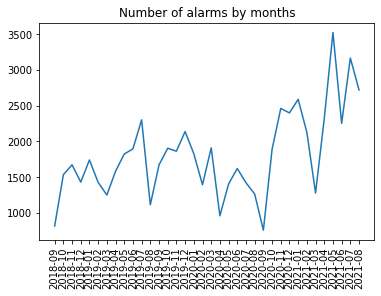

In [10]:
##### Check how many alarms happen on each month from 2018 #####

wba127_alarm['YEAR MONTH'] = wba127_alarm['DT_SET'].dt.strftime('%Y-%m')

freq_by_month = wba127_alarm.groupby(['YEAR MONTH']).size()

plt.plot(freq_by_month.index, freq_by_month.values)
plt.xticks(rotation=90)
plt.title('Number of alarms by months')
plt.show()

# notice 2021-06 has the highest number of alarm occurence

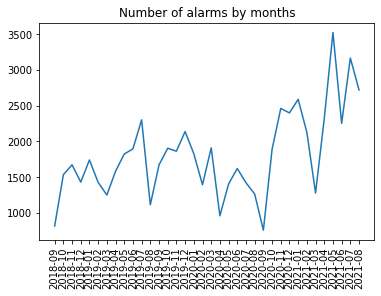

In [30]:
# see if we can observe this trend from WBA124
down_by_month = wba127_alarm.groupby(['YEAR MONTH']).agg({'24 HOUR DOWN':'count'})

plt.plot(down_by_month.index, down_by_month.values)
plt.xticks(rotation=90)
plt.title('Number of alarms by months')
plt.show()

In [11]:
# ratio of each alarm between positive and negative class
positive = wba127_alarm[wba127_alarm['24 HOUR DOWN']==1]
negative = wba127_alarm[wba127_alarm['24 HOUR DOWN']==0]

# pos:neg = 0.63
pos_to_neg_ratio = len(positive)/len(negative)

ratio = {}
pos_alarms = positive['Alarm ID'].value_counts().to_dict()
neg_alarms = negative['Alarm ID'].value_counts().to_dict()

for key, val in pos_alarms.items():
    if key in neg_alarms.keys():
        ratio[key] = val/neg_alarms[key]
        continue
    ratio[key] = 'Alarm cannot be found in the negative classes'
ratio

# top few most influential alarms appear with the same frequencies
# the pos:neg ratio are very similar to the class distribution between class 0 and 1
# the hypothesis that sudden increase in alarm occurence leading to major down is disproved

{46: 0.7513494889169634,
 45: 0.6535081967213114,
 28: 0.6299870105771015,
 44: 0.8071051086318262,
 24: 1.1224632610216936,
 11: 0.2885646217986897,
 23: 0.5154083204930663,
 150: 0.46015246015246014,
 73: 0.3683901292596945,
 33: 0.52319309600863,
 3: 1.3461538461538463,
 27: 1.619718309859155,
 151: 0.4109848484848485,
 51: 0.4288577154308617,
 47: 0.519280205655527,
 80: 0.3176043557168784,
 65: 1.6595744680851063,
 61: 0.34624697336561744,
 26: 0.8597560975609756,
 12: 0.31786542923433875,
 2: 2.1864406779661016,
 10: 0.36394557823129253,
 89: 0.3037974683544304,
 5: 0.3565217391304348,
 90: 0.7362637362637363,
 4: 0.32903225806451614,
 20: 0.3939393939393939,
 8: 1.588235294117647,
 19: 0.65,
 49: 0.47619047619047616,
 50: 0.5,
 18: 0.47368421052631576,
 13: 0.15555555555555556,
 14: 0.5384615384615384,
 35: 0.375,
 6: 0.2857142857142857,
 146: 0.6,
 147: 0.09090909090909091,
 245: 0.5,
 25: 0.1}

# 2. EDA does not seem to suggest for us to remove anything, proceed with feature engineering

In [4]:
query_filter = (wba127_status.LEVEL3=='UDT') & (wba127_status.DURATION>=3600)
wba127_failure = wba127_status.loc[query_filter].reset_index(drop=True)

In [5]:
# drop rows with no alarm end time
# EDA suggests that there are rows with null values
wba127_alarm_n = wba127_alarm.loc[wba127_alarm.DT_CLEAR.notnull()].reset_index(drop=True)


##### FEATURE ENGINEERING: compute the time since last alarm #####
wba127_alarm_n['TIME SINCE LAST ALARM'] = (wba127_alarm_n['DT_SET'] - wba127_alarm_n['DT_SET'].shift(1)).dt.total_seconds()


##### Slice alarm table to make sure it is a subset of the status table #####
status_start = wba127_status.iloc[0]['TIMESTAMP_START']
query_filter = wba127_alarm_n.DT_SET > status_start
wba127_alarm_n = wba127_alarm_n[query_filter].reset_index(drop=True)


##### Calculate Time to Failure #####
failure_idx = 0
time_to_failure = []
for idx, row in wba127_alarm_n.iterrows():
    failure_time = wba127_failure.iloc[failure_idx]['TIMESTAMP_START']
    
    while row['DT_SET'] >= failure_time:
        failure_idx += 1
        failure_time = wba127_failure.iloc[failure_idx]['TIMESTAMP_START']

    ttf = (failure_time-row['DT_SET']).total_seconds()
    time_to_failure.append(ttf)

wba127_alarm_n['TTF'] = time_to_failure

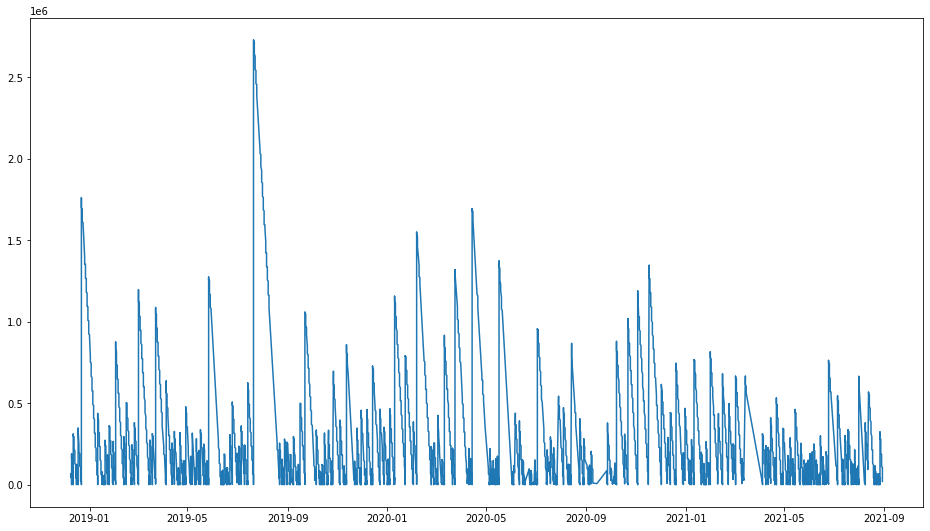

In [6]:
##### Visualize TTF #####
date = wba127_alarm_n['DT_SET'].dt.date
ttf_y = wba127_alarm_n['TTF'].values

# notice that there is a long period of time with no alarm at all
plt.figure(figsize=(16,9))
plt.plot(date, ttf_y)
plt.show()

In [7]:
lb = LabelEncoder()
enc_alarm = lb.fit_transform(wba127_alarm_n['Alarm ID'])
wba127_alarm_n['ENC ALARM'] = enc_alarm

features = ['ENC ALARM', 'TIME SINCE LAST ALARM', 'TTF']
df = wba127_alarm_n[features]

In [8]:
# introduce lagging and rolling to predict TTF
##### Lag 
lags = [1,2,3,4,5]
for lag in lags:
    df[f'ENC ALARM LAGGED {lag}'] = df['ENC ALARM'].shift(lag)
    df[f'TIME SINCE LAST ALARM LAGGED {lag}'] = df['TIME SINCE LAST ALARM'].shift(lag)
    
##### Rolling aggregation of DURATION and TIME SINCE FAILURE #####
rolling = [5, 10, 15, 20]
for roll in rolling:
    df[f'TIME SINCE LAST ALARM ROLL {roll}'] = df['TIME SINCE LAST ALARM'].rolling(roll).mean()

df = df.dropna()

In [9]:
data = df.drop(['TTF'], axis=1)
target = df['TTF']

In [32]:
# basic input df to predict TIME TO FAILURE
data

,ENC ALARM,TIME SINCE LAST ALARM,ENC ALARM LAGGED 1,TIME SINCE LAST ALARM LAGGED 1,ENC ALARM LAGGED 2,TIME SINCE LAST ALARM LAGGED 2,ENC ALARM LAGGED 3,TIME SINCE LAST ALARM LAGGED 3,ENC ALARM LAGGED 4,TIME SINCE LAST ALARM LAGGED 4,ENC ALARM LAGGED 5,TIME SINCE LAST ALARM LAGGED 5,TIME SINCE LAST ALARM ROLL 5,TIME SINCE LAST ALARM ROLL 10,TIME SINCE LAST ALARM ROLL 15,TIME SINCE LAST ALARM ROLL 20
19,9,5915.0,9.0,1229.0,36.0,48.0,37.0,3120.0,28.0,2692.0,35.0,3054.0,2600.8,3116.0,2534.933333,2181.95
20,20,10926.0,9.0,5915.0,9.0,1229.0,36.0,48.0,37.0,3120.0,28.0,2692.0,4247.6,4084.9,3174.200000,2719.15
21,26,191.0,20.0,10926.0,9.0,5915.0,9.0,1229.0,36.0,48.0,37.0,3120.0,3661.8,3800.6,3040.133333,2725.20
22,26,10.0,26.0,191.0,20.0,10926.0,9.0,5915.0,9.0,1229.0,36.0,48.0,3654.2,3298.5,3035.600000,2711.60
23,17,137.0,26.0,10.0,26.0,191.0,20.0,10926.0,9.0,5915.0,9.0,1229.0,3435.8,2732.2,2887.866667,2560.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61130,21,79.0,28.0,113.0,27.0,714.0,27.0,17.0,21.0,59.0,21.0,206.0,196.4,291.4,297.066667,287.95
61131,21,15.0,21.0,79.0,28.0,113.0,27.0,714.0,27.0,17.0,21.0,59.0,187.6,129.3,246.000000,287.60
61132,28,16.0,21.0,15.0,21.0,79.0,28.0,113.0,27.0,714.0,27.0,17.0,187.4,129.4,231.533333,287.15
61133,28,56.0,28.0,16.0,21.0,15.0,21.0,79.0,28.0,113.0,27.0,714.0,55.8,133.9,234.400000,287.00


In [11]:
##### test train split #####
##### X_train contains 2 features, ENC ALarm and TIME SINCE LAST ALARM #####

train_idx = int(0.7*len(data))
val_idx = int(0.8*(len(data)))

X_train, y_train = data[:train_idx], target[:train_idx]
X_val, y_val = data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = data[val_idx:], target[val_idx:]

In [30]:
reg = lightgbm.LGBMRegressor(
        objective="regression",
        n_estimators=5000,
        learning_rate=0.05,
        importance_type="gain",
        max_depth = 3
    )

reg.fit(X_train, y_train,
       eval_set=[(X_val, y_val)],
       eval_metric='mae',
       early_stopping_rounds=20)

from sklearn.metrics import mean_squared_error

y_predicted = reg.predict(X_test)

rms = mean_squared_error(y_test, y_predicted, squared=True)
rms

[1]	valid_0's l1: 181278	valid_0's l2: 4.37579e+10
[2]	valid_0's l1: 181084	valid_0's l2: 4.37433e+10
[3]	valid_0's l1: 180903	valid_0's l2: 4.37427e+10
[4]	valid_0's l1: 180781	valid_0's l2: 4.378e+10
[5]	valid_0's l1: 180702	valid_0's l2: 4.38281e+10
[6]	valid_0's l1: 180539	valid_0's l2: 4.3855e+10
[7]	valid_0's l1: 180524	valid_0's l2: 4.39134e+10
[8]	valid_0's l1: 180456	valid_0's l2: 4.39563e+10
[9]	valid_0's l1: 180440	valid_0's l2: 4.40343e+10
[10]	valid_0's l1: 180427	valid_0's l2: 4.41212e+10
[11]	valid_0's l1: 180554	valid_0's l2: 4.42029e+10
[12]	valid_0's l1: 180584	valid_0's l2: 4.42917e+10
[13]	valid_0's l1: 180627	valid_0's l2: 4.43913e+10
[14]	valid_0's l1: 180613	valid_0's l2: 4.44513e+10
[15]	valid_0's l1: 180666	valid_0's l2: 4.45627e+10
[16]	valid_0's l1: 180861	valid_0's l2: 4.47169e+10
[17]	valid_0's l1: 180843	valid_0's l2: 4.48109e+10
[18]	valid_0's l1: 180918	valid_0's l2: 4.49067e+10
[19]	valid_0's l1: 180936	valid_0's l2: 4.50109e+10
[20]	valid_0's l1: 18096

51132863423.18121

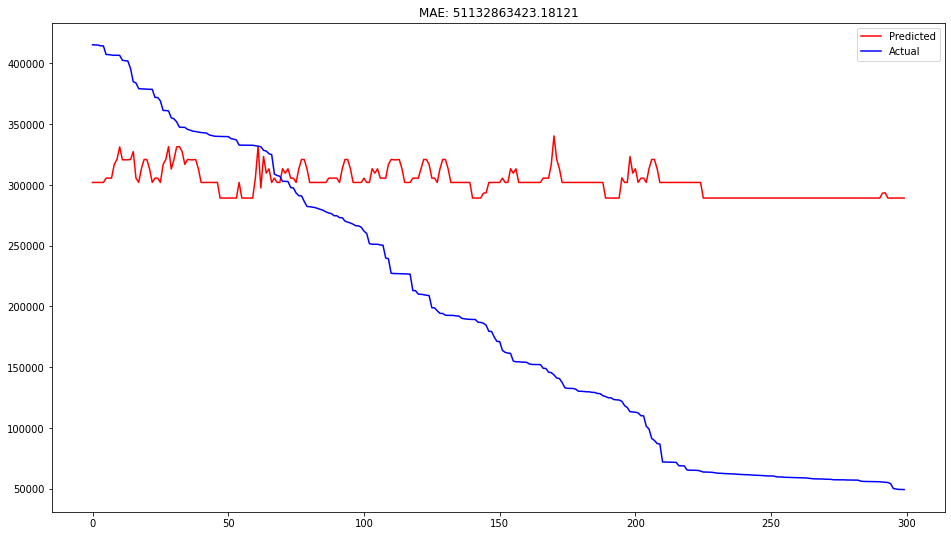

In [31]:
x = range(len(y_test[:300]))
plt.figure(figsize=(16,9))
plt.plot(x, y_predicted[:300], color='red', label='Predicted')
plt.plot(x, y_test[:300], color='blue', label='Actual')
plt.title(f'MAE: {rms}')
plt.legend()
plt.show()

In [ ]:
##### Check alarm frequencies #####
wba127_alarm_n['Alarm ID'].value_counts()

In [ ]:
wba127_alarm_n.reset_index(drop=True, inplace=True)
wba127_alarm_n.loc[wba127_alarm_n['Alarm ID']==31]

In [ ]:
store -r wba127_clean_status

In [ ]:
# find out what is the EQ state name when the alarm happens
wba127_clean_status.head(50)

In [ ]:
# check what is the status of the machine at the start time of the alarm
# we want the status that starts at the alarm trigger, not the one ending (for alarm dt_set == state name end time)

LEVEL3 = []
STATE_NAME = []
STATE_DURATION = []

for idx, row in wba127_alarm_n.iterrows():
    alarm_start = row['DT_SET']
    query_filter = (wba127_clean_status['TIMESTAMP_START']<=alarm_start) & (wba127_clean_status['TIMESTAMP_END']>alarm_start)
    filtered = wba127_clean_status[query_filter]
    
    if len(filtered)>1:
        print(alarm_start, filtered)
        raise Exception('Multiple status within this time')
    elif len(filtered) == 0:
        LEVEL3.append(0)
        STATE_NAME.append(0)
        STATE_DURATION.append(0)
        continue
    
    LEVEL3.append(filtered.iloc[0]['LEVEL3'])
    STATE_NAME.append(filtered.iloc[0]['STATE_NAME'])
    STATE_DURATION.append(filtered.iloc[0]['DURATION'])

wba127_alarm_n['LEVEL3'] = LEVEL3
wba127_alarm_n['STATE_NAME'] = STATE_NAME
wba127_alarm_n['STATE NAME DURATION'] = STATE_DURATION

In [ ]:
# inspect rows with 0 as level3
wba127_alarm_n[wba127_alarm_n['STATE_NAME']==0]

# 3 of them are all from 2019-02-13, this is the period where TFM database have no records, because of an exceptionally long PlanIdle

In [ ]:
# remove rows with no state name and level3, make sure all those with 0 LEVEL3 has been removed by comparing against the above
wba127_alarm_n = wba127_alarm_n[~(wba127_alarm_n.LEVEL3==0)]
wba127_alarm_n['LEVEL3'].value_counts()

In [ ]:
wba127_alarm_n['Alarm ID'].value_counts()

In [ ]:
rare_alarms = [34, 1, 100, 245, 31, 9, 146]
wba127_alarm_n_r = wba127_alarm_n[~(wba127_alarm_n['Alarm ID'].isin(rare_alarms))]

In [ ]:
# label encode all categorical columns

wba127_alarm_n_r['ENC STATE_NAME'] = lb.fit_transform(wba127_alarm_n_r['STATE_NAME'])
wba127_alarm_n_r['ENC LEVEL3'] = lb.fit_transform(wba127_alarm_n_r['LEVEL3'])
wba127_alarm_n_r

In [ ]:
##### Compute major down for each alarm #####

# put equal sign on start and end time, just in case the alarm also marks the start of a major down

hour = 24
threshold = 3600

MAJOR_DOWN = []
for idx, row in wba127_alarm_n_r.iterrows():
    start = row['DT_SET']
    end = start+timedelta(hours=hour)
    frame = wba127_clean_status[(wba127_clean_status['TIMESTAMP_START']>=start) & \
                                 (wba127_clean_status['TIMESTAMP_START']<=end)]
    UD = frame.loc[frame['LEVEL3']=='UDT']

    if len(UD) == 0: #no record within this 6 hours:
        MAJOR_DOWN.append(0)
    else:
        time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
        if any(time_diff>=threshold): #threshold = 3600s
            MAJOR_DOWN.append(1)
        else:
            MAJOR_DOWN.append(0)

wba127_alarm_n_r['24 HOUR DOWN'] = MAJOR_DOWN

In [ ]:
features = ['ENC ALARM', 'ENC STATE_NAME', 'ENC LEVEL3',
            'STATE NAME DURATION', 'TIME SINCE LAST ALARM']

df = wba127_alarm_n_r[features]
target = wba127_alarm_n_r['24 HOUR DOWN']

In [ ]:
# the dataset that is being fed into the model
df

In [ ]:
train_idx = int(0.7*len(df))
val_idx = int(0.8*(len(df)))

X_train, y_train = df[:train_idx], target[:train_idx]
X_val, y_val = df[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = df[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=True)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)

# before introducing duration
# (array([[1745, 1475],
#         [ 951, 1193]]),
#  0.5477255779269202)

# after introducing duration
# (array([[1829, 1391],
#         [1058, 1086]]),
#  0.5434377330350485)

In [ ]:
# notice that 2020 Jan/ 2021 Apr and 2021 May suddenly has alot of alarms
# check whether are there more major down with the increase in alarms

any_month = wba127_alarm_n_r[wba127_alarm_n_r['YEAR MONTH']=='2019-08']
jan = wba127_alarm_n_r[wba127_alarm_n_r['YEAR MONTH']=='2020-01']
apr = wba127_alarm_n_r[wba127_alarm_n_r['YEAR MONTH']=='2021-04']
may =wba127_alarm_n_r[wba127_alarm_n_r['YEAR MONTH']=='2021-05']

any_month['24 HOUR DOWN'].value_counts(), jan['24 HOUR DOWN'].value_counts(), apr['24 HOUR DOWN'].value_counts(), may['24 HOUR DOWN'].value_counts()

In [ ]:
features = ['ENC ALARM', 'ENC STATE_NAME', 'ENC LEVEL3',
            'STATE NAME DURATION', 'TIME SINCE LAST ALARM']

new_df = wba127_alarm_n_r[features]
target = wba127_alarm_n_r['24 HOUR DOWN']

##### Lag 
lags = [1,2,3,4,5]
for lag in lags:
    new_df[f'STATE NAME DURATION LAGGED {lag}'] = new_df['STATE NAME DURATION'].shift(lag)
    new_df[f'ENC STATE NAME LAGGED {lag}'] = new_df['ENC STATE_NAME'].shift(lag)
    new_df[f'ENC ALARM LAGGED {lag}'] = new_df['ENC ALARM'].shift(lag)
    new_df[f'ENC LEVEL3 LAGGED {lag}'] = new_df['ENC LEVEL3'].shift(lag)
    new_df[f'TIME SINCE LAST ALARM LAGGED {lag}'] = new_df['TIME SINCE LAST ALARM'].shift(lag)
    
##### Rolling aggregation of DURATION and TIME SINCE FAILURE #####
rolling = [5, 10, 15, 20]
for roll in rolling:
    new_df[f'STATE NAME DURATION ROLL {roll}'] = new_df['STATE NAME DURATION'].rolling(roll).mean()
    new_df[f'TIME SINCE LAST ALARM ROLL {roll}'] = new_df['TIME SINCE LAST ALARM'].rolling(roll).mean()

In [ ]:
# convert ENC Alarm back to integer
categorical_columns = ['ENC STATE NAME LAGGED 1', 'ENC STATE NAME LAGGED 2', 'ENC STATE NAME LAGGED 3',\
                      'ENC STATE NAME LAGGED 4', 'ENC STATE NAME LAGGED 5', 'ENC ALARM LAGGED 1',\
                      'ENC ALARM LAGGED 2', 'ENC ALARM LAGGED 3', 'ENC ALARM LAGGED 4', 'ENC ALARM LAGGED 5',\
                      'ENC LEVEL3 LAGGED 1', 'ENC LEVEL3 LAGGED 2', 'ENC LEVEL3 LAGGED 3', 'ENC LEVEL3 LAGGED 4',\
                      'ENC LEVEL3 LAGGED 5']

# join two tables together to drop na
tmp_table = pd.concat([new_df, target], axis=1)
tmp_table = tmp_table.dropna()
tmp_table[categorical_columns] = tmp_table[categorical_columns].astype('int')


df = tmp_table.drop(['24 HOUR DOWN'], axis=1)
target = tmp_table['24 HOUR DOWN']

In [ ]:
# how the training input looks like
df

In [ ]:
train_idx = int(0.7*len(df))
val_idx = int(0.8*(len(df)))

X_train, y_train = df[:train_idx], target[:train_idx]
X_val, y_val = df[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = df[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='dart',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    early_stopping_rounds=15,
    num_leaves=50,
    learning_rate=0.05,
    lambda_l2=0.01,
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=False)

training_score = clf.score(X_train, y_train)
pred = clf.predict(X_test)

print(f'Training score: {training_score}, test score: {accuracy_score(y_test, pred)}')
confusion_matrix(y_test, pred)

# without adjusting num leaves
# (array([[1999, 1217],
#         [1007, 1137]]),
#  0.5850746268656717)

In [ ]:
# (array([[2615, 1992],
#         [1238, 1474]]),
#  0.5586828801748873)

# small num leaves with dart
# (array([[2616, 1991],
#         [1162, 1550]]),
#  0.5692034430933187)

# gbdt
# (array([[2545, 2062],
#         [1107, 1605]]),
#  0.5670173520972811)

In [31]:
data

NameError: name 'data' is not defined